Import used libraries and load input data:
- Photoluminescence
- Photoreflection

In [89]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

pl07wr_df = pd.read_csv('data/PL_NP7811_laser_0p7mW_wide_range.txt', sep='\t')
pl07wr_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pl07wr_df = pl07wr_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)
                     
pl25_df = pd.read_csv('data/PL_NP7811_laser_2p5mW.txt', sep='\t')
pl25_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pl25_df = pl25_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)

pr07wr_df = pd.read_csv('data/PR_NP7811_laser_0p7mW_wide_range.txt', sep='\t')
pr07wr_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pr07wr_df = pr07wr_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)

pr25_df = pd.read_csv('data/PR_NP7811_laser_2p5mW.txt', sep='\t')
pr25_df.columns = ['energy', 'AC_X', 'AC_Y', 'AC_R', 'DC_R']
pr25_df = pr25_df.sort_values(by=['energy'], ascending=True).reset_index(drop=True)


Fitting function for photoreflectance

$
\displaystyle
y(x) = A + Bx + Cx^2 + \frac{D_1}{\left( (x - E_1)^2 + {G_1}^2 \right)^{\frac{n}{2}}} \cdot \cos\left( T_1 - n\left( \frac{\pi}{2} - \tan^{-1}\left( \frac{x - E_1}{G_1} \right) \right) \right)
$

In [90]:
def fit_pr1_generic(n):
    def fit_pr1(x, A, B, C, D1, T1, E1, G1):
        term1 = A + B * x + C * x**2
        denom = ((x - E1)**2 + G1**2)**(n / 2)
        angle = T1 - n * (np.pi / 2 - np.arctan((x - E1) / G1))
        return term1 + (D1 / denom) * np.cos(angle)
    return fit_pr1

def fit_pr1_to_dict(params):
    return {
        'A1': params[0],
        'B1': params[1],
        'C1': params[2],
        'D1': params[3],
        'T1': params[4],
        'E1': params[5],
        'G1': params[6],
    }

def fit_pr1_reduced_generic(n):
    def fit_pr1_reduced(x, D1, T1, E1, G1):
        denom = ((x - E1)**2 + G1**2)**(n / 2)
        angle = T1 - n * (np.pi / 2 - np.arctan((x - E1) / G1))
        return (D1 / denom) * np.cos(angle)
    return fit_pr1_reduced

def fit_pr2_generic(n):
    def fit_pr2(x, A1, B1, C1, D1, T1, E1, G1, D2, T2, E2, G2):
        fit1 = fit_pr1_generic(n)(x, A1, B1, C1, D1, T1, E1, G1)
        fit2 = fit_pr1_reduced_generic(n)(x, D2, T2, E2, G2)
        return fit1 + fit2
    return fit_pr2

def fit_pr2_to_dict(params):
    return {
        'A1': params[0],
        'B1': params[1],
        'C1': params[2],
        'D1': params[3],
        'T1': params[4],
        'E1': params[5],
        'G1': params[6],
        'D2': params[7],
        'T2': params[8],
        'E2': params[9],
        'G2': params[10],
    }

Fitting function for module

$
\displaystyle
\frac{|\!D\!|}{\left( (x - E)^2 + G^2 \right)^{\frac{n}{2}}}
$

In [91]:
def fit_module_generic(n):
    def fit_module(x, D, E, G):
        denom = ((x - E)**2 + G**2)**(n / 2)
        return np.abs(D)/denom
    return fit_module

def fit_module1_calc(n, x, params_dict):
    D = params_dict['D1']
    E = params_dict['E1']
    G = params_dict['G1']
    return fit_module_generic(n)(x, D, E, G)

def fit_module2_calc(n, x, params_dict):
    D1 = params_dict['D1']
    E1 = params_dict['E1']
    G1 = params_dict['G1']
    fit1 = fit_module_generic(n)(x, D1, E1, G1)
    D2 = params_dict['D2']
    E2 = params_dict['E2']
    G2 = params_dict['G2']
    fit2 = fit_module_generic(n)(x, D2, E2, G2)
    return fit1 + fit2

def fit_module12_calc(n, x, params_dict):
    D2 = params_dict['D2']
    E2 = params_dict['E2']
    G2 = params_dict['G2']
    fit2 = fit_module_generic(n)(x, D2, E2, G2)
    return fit2

def fit_moduleN_calc(n, x, sd, params_dict):
    if sd == 1:
        return fit_module1_calc(n, x, params_dict)
    elif sd == 2:
        return fit_module2_calc(n, x, params_dict)
    else:
        raise Exception("Not supported")
        

Print all dataset to confirm everything is fine

In [92]:
print(f'Photoluminescence 0.7mW laser (wide-range): \n {pl07wr_df}')
print(f'Photoluminescence 2.5mW laser: \n {pl25_df}')
print(f'Photoreflection 0.7mW laser: \n {pr07wr_df}')
print(f'Photoluminescence 2.5mW laser: \n {pl25_df}')

Photoluminescence 0.7mW laser (wide-range): 
       energy          AC_X          AC_Y          AC_R      DC_R
0     1.0995 -2.185517e-07 -3.178930e-07  2.980247e-07  0.011333
1     1.1000 -4.371030e-07 -3.774987e-07  5.165773e-07  0.010222
2     1.1005 -1.351043e-06  8.742060e-07  1.589463e-06  0.011000
3     1.1010 -1.370910e-06  2.980250e-07  1.370913e-06  0.011000
4     1.1015 -7.748640e-07 -1.152363e-06  1.291440e-06  0.012444
...      ...           ...           ...           ...       ...
1196  1.6975 -7.351290e-07 -7.549957e-07  1.013288e-06  0.010444
1197  1.6980 -1.986830e-07 -3.178933e-07  3.377613e-07  0.010889
1198  1.6985  1.390783e-07 -1.152363e-06  1.092763e-06  0.010111
1199  1.6990 -5.761813e-07 -8.146017e-07  9.338137e-07  0.012444
1200  1.6995 -7.748640e-07 -1.668937e-06  1.768280e-06  0.013556

[1201 rows x 5 columns]
Photoluminescence 2.5mW laser: 
      energy          AC_X      AC_Y      AC_R      DC_R
0     1.099 -1.270330e-05  0.000082 -0.000084  0.020556
1   

In [93]:
from dataclasses import dataclass

@dataclass
class Result:
    # Name of result set
    name: str
    # Color used on charts
    color: str
    # Related energy range 
    energy_start: float
    energy_stop: float
    energy_idx_start: int
    energy_idx_stop: int
    # Single/Double fit
    sd: int
    # PR fit n
    n: int
    # Params fitted from PR
    fitted_params: {}
    covariance: [float]
    y_fitted: [float]
    x_fit: [float]

global_results_wr = {}

# Plotting

## Photoluminescence
Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

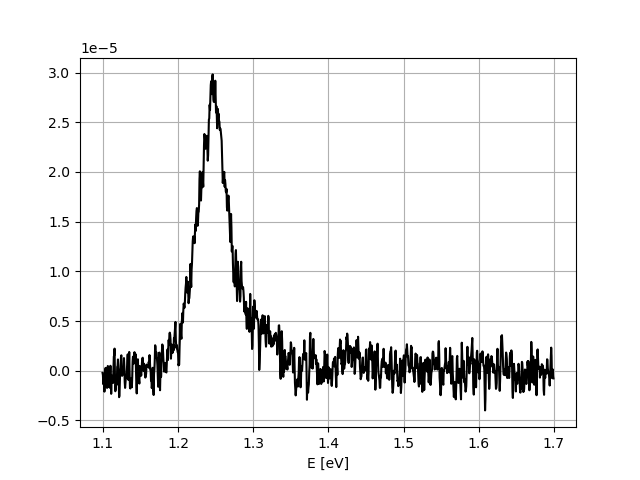

In [94]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']

plt.figure()
plt.plot(energy_wr, pl_wr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## Photoluminescence
Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

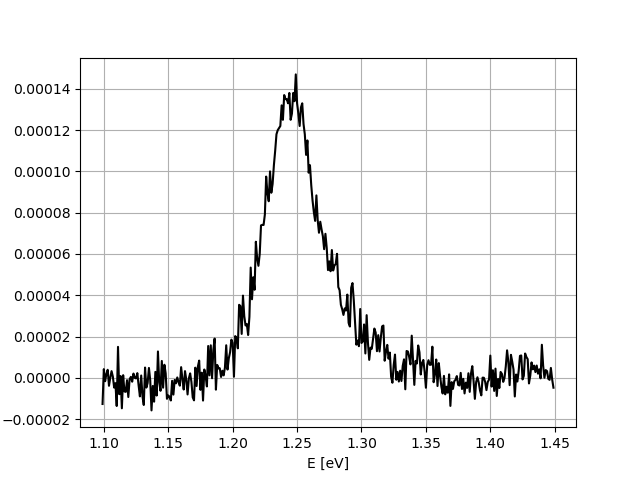

In [95]:
energy = pl25_df['energy']
pl = pl25_df['AC_X']

plt.figure()
plt.plot(energy, pl, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# Photoreflectance

Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

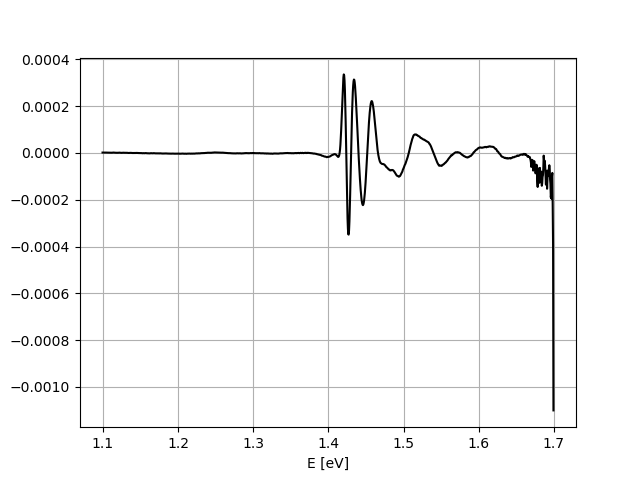

In [96]:
energy_wr = pl07wr_df['energy']
pl_wr = pl07wr_df['AC_X']
pr_wr = pr07wr_df['AC_X']
r_wr = pr07wr_df['DC_R']
y_wr = (pr_wr-pl_wr)/r_wr

plt.figure()
plt.plot(energy_wr, y_wr, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

## I transition
Here I will try to fit function to first transition. \
Teacher advised me to use doubled fit function for the first transition.

Fitting from 1.415 eV to 1.4400507 eV, idx: 631, 681
Params [ 3.32312815e+00 -4.62700830e+00  1.61034214e+00  1.10914547e-07
 -3.76806023e+00  1.42284120e+00 -8.52904950e-03  2.33910007e-07
 -1.87943283e+00  1.42870285e+00 -1.16238403e-02]
 Covariance: [[ 6.48829117e-01 -9.08113820e-01  3.17715149e-01  8.47780028e-09
  -9.66995221e-02  1.49599262e-04 -7.29852468e-05  3.10678461e-08
  -7.57182228e-02 -1.14217933e-05 -3.66481443e-04]
 [-9.08113820e-01  1.27101704e+00 -4.44682608e-01 -1.18510116e-08
   1.35401582e-01 -2.09417674e-04  1.01941225e-04 -4.34660780e-08
   1.06104634e-01  1.55912105e-05  5.12981588e-04]
 [ 3.17715149e-01 -4.44682608e-01  1.55578667e-01  4.14109555e-09
  -4.73924666e-02  7.32796796e-05 -3.55919784e-05  1.52011707e-08
  -3.71666909e-02 -5.31675114e-06 -1.79489238e-04]
 [ 8.47780028e-09 -1.18510116e-08  4.14109555e-09  1.82522188e-16
  -1.03464388e-09  1.88495137e-12 -1.97202652e-12  4.91506943e-16
  -4.05439559e-10 -2.03311491e-12 -4.61481868e-12]
 [-9.66995221e-

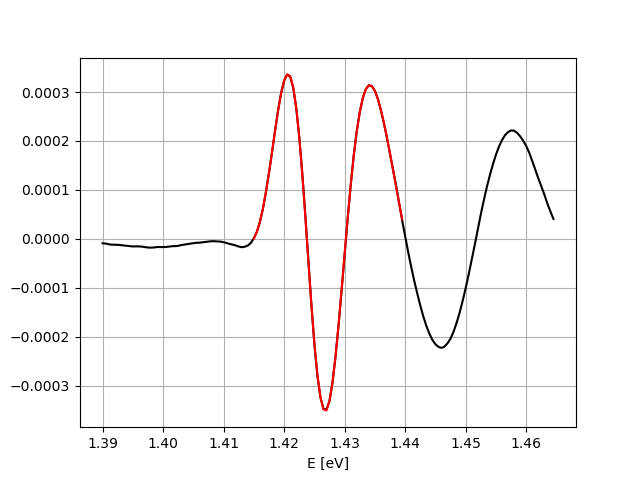

In [97]:
# Fitting range for the first transition
start_energy, stop_energy = 1.4150, 1.4400507

# Fitting params
n = 2
params1 = [
    1.30246864e+00,  #A1
    -1.80140004e+00, #B1 
    6.22648896e-01,  #C1
    7.56386049e-08,  #D1
    -3.57483951e+00, #T1 
    1.42247817e+00,  #E1
    -8.05044852e-03  #G1
]
params2 = [
    1.47047956e-07,  #D2
    -1.74818495e+00, #T2
    1.42897126e+00,  #E2
    -1.05916087e-02  #G2
]

# Double function used
fit_pr = fit_pr2_generic(n)

# Both-sided context
margin_idx = 50

start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1 + params2
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='red')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()
    
global_results_wr['T1'] = Result(
    name = 'PR WR I transition',
    color = 'red',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 2,
    n = n,
    fitted_params = fit_pr2_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## II transition

[1.30246864, -1.80140004, 0.622648896, 7.56386049e-08, -3.57483951, 1.42247817, -0.00805044852, 1.47047956e-07, -1.74818495, 1.42897126, -0.0105916087]
Fitting from 1.4400507 eV to 1.466 eV, idx: 681, 733
Params [ 3.03332429e+00 -4.14810262e+00  1.41795846e+00  1.56575909e-07
  2.06235657e+00  1.45296799e+00  1.48004429e-02]
 Covariance: [[ 2.70859036e-02 -3.72984811e-02  1.28389421e-02  5.29278255e-10
   7.22791487e-03  2.47833306e-05  1.13616270e-05]
 [-3.72984811e-02  5.13618062e-02 -1.76798959e-02 -7.27863168e-10
  -9.95624145e-03 -3.41402156e-05 -1.56196646e-05]
 [ 1.28389421e-02 -1.76798959e-02  6.08583872e-03  2.50209858e-10
   3.42821067e-03  1.17560724e-05  5.36773647e-06]
 [ 5.29278255e-10 -7.27863168e-10  2.50209858e-10  1.67466012e-17
   1.24230852e-10  4.17711857e-13  3.94276704e-13]
 [ 7.22791487e-03 -9.95624145e-03  3.42821067e-03  1.24230852e-10
   2.02276072e-03  7.03524031e-06  2.59300922e-06]
 [ 2.47833306e-05 -3.41402156e-05  1.17560724e-05  4.17711857e-13
   7.0352

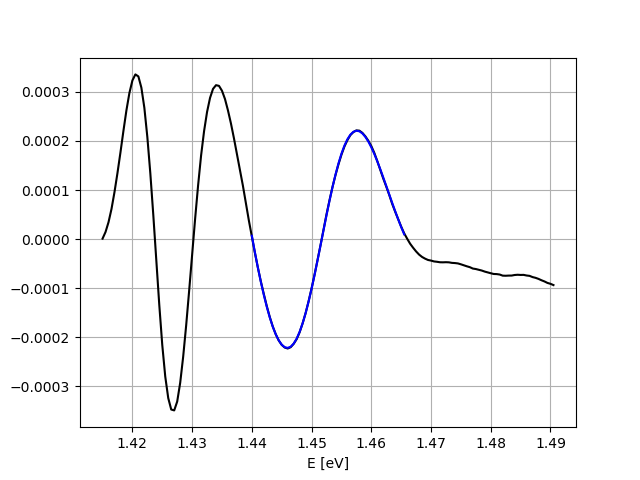

In [98]:
# Fitting range for the second transition
start_energy, stop_energy = 1.4400507, 1.466

# Fitting params
n = 2
params1 = [
    7.79067537e-01,  #A1
    -1.03719700e+00, #B1
    3.44798239e-01,  #C1
    1.72295879e-07,  #D1
    1.48424046e+00,  #T1
    1.45111328e+00,  #E1
    1.52253710e-02   #G1
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='blue')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T2'] = Result(
    name = 'PR WR II transition',
    color = 'green',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## III transition

[0.779067537, -1.037197, 0.344798239, 1.72295879e-07, 1.48424046, 1.45111328, 0.015225371]
Fitting from 1.466 eV to 1.541 eV, idx: 733, 883
Params [ 6.78381530e-03 -8.63766506e-03  2.73739166e-03  7.55044673e-08
  1.70402503e+00  1.50677304e+00  2.29672009e-02]
 Covariance: [[ 1.61120253e-04 -2.14733743e-04  7.15141923e-05 -1.83633074e-11
   1.23408230e-03  8.79985299e-06 -1.99531360e-06]
 [-2.14733743e-04  2.86194584e-04 -9.53156712e-05  2.48174946e-11
  -1.64432741e-03 -1.17236079e-05  2.69736690e-06]
 [ 7.15141923e-05 -9.53156712e-05  3.17452073e-05 -8.37960463e-12
   5.47474385e-04  3.90278208e-06 -9.11008332e-07]
 [-1.83633074e-11  2.48174946e-11 -8.37960463e-12  2.05005853e-17
  -1.21886322e-10 -7.91933568e-13  2.35663286e-12]
 [ 1.23408230e-03 -1.64432741e-03  5.47474385e-04 -1.21886322e-10
   1.04820773e-02  7.80246712e-05 -1.34617033e-05]
 [ 8.79985299e-06 -1.17236079e-05  3.90278208e-06 -7.91933568e-13
   7.80246712e-05  6.00897366e-07 -8.80163764e-08]
 [-1.99531360e-06  2.69

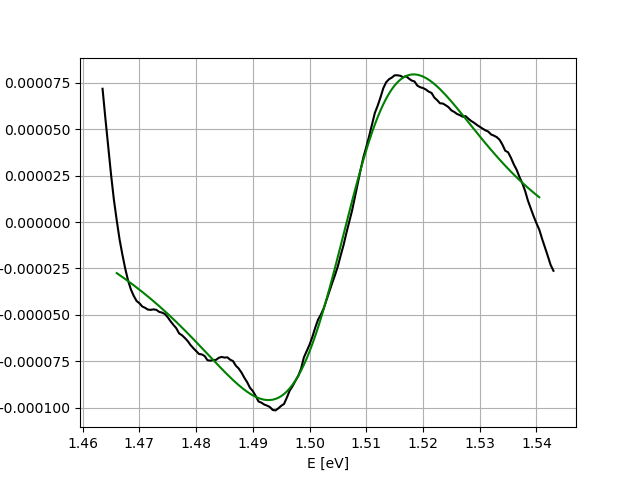

In [99]:
# Fitting range for the third transition
start_energy, stop_energy = 1.466, 1.541

# Fitting params
n = 2
#          A1    B1    C1   D1      T1   E1    G1 
params1 = [
    1.71904595e-02,  #A1 
    -2.12480727e-02, #B1 
    6.51766373e-03,  #C1
    1.45073010e-07,  #D1
    1.81176687e+00,  #T1
    1.50783357e+00,  #E1
    2.29672002e-02,  #G1
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 5

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=100000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='green')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T3'] = Result(
    name = 'PR WR III transition',
    color = 'blue',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)


## VI transition

[0.0171904595, -0.0212480727, 0.00651766373, 1.4507301e-07, 1.81176687, 1.50783357, 0.0229672002]
Fitting from 1.541 eV to 1.5928 eV, idx: 883, 987
Params [ 1.28674305e+00 -1.63952617e+00  5.21986552e-01  1.77900744e-06
  3.42554631e+00  1.56574529e+00 -5.11520708e-02]
 Covariance: [[ 3.12914014e-02 -3.99487248e-02  1.27391432e-02  1.14482810e-07
  -1.21563442e-02  1.08412100e-04 -6.33155895e-04]
 [-3.99487248e-02  5.10017833e-02 -1.62639932e-02 -1.46137012e-07
   1.55812124e-02 -1.39136546e-04  8.08209381e-04]
 [ 1.27391432e-02 -1.62639932e-02  5.18648967e-03  4.65949612e-08
  -4.98823684e-03  4.46010643e-05 -2.57688800e-04]
 [ 1.14482810e-07 -1.46137012e-07  4.65949612e-08  4.20746710e-13
  -4.23323687e-08  3.71457916e-10 -2.33083958e-09]
 [-1.21563442e-02  1.55812124e-02 -4.98823684e-03 -4.23323687e-08
   1.18791725e-02 -1.27145240e-04  2.32988809e-04]
 [ 1.08412100e-04 -1.39136546e-04  4.46010643e-05  3.71457916e-10
  -1.27145240e-04  1.38723269e-06 -2.04148851e-06]
 [-6.33155895e-

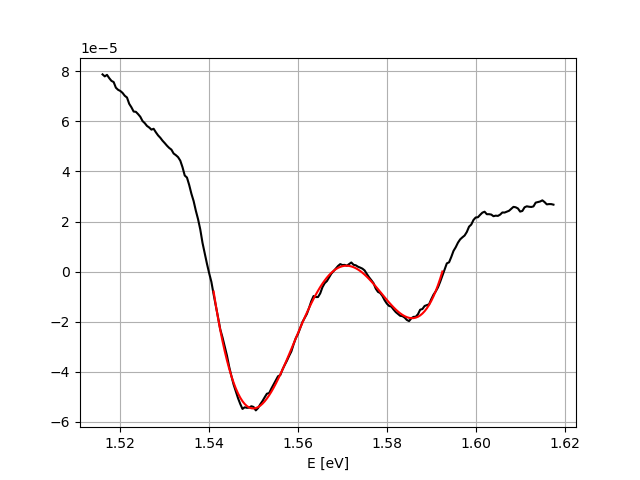

In [100]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.541, 1.5928

# Fitting params
n = 2
params1 = [
    6.72477182e+00,  #A1
    -8.81517954e+00, #B1
    2.88791745e+00,  #C1
    1.62472063e-04,  #D1
    1.28395976e-01,  #T1
    1.63030533e+00,  #E1
    -8.75827670e-02  #G1
]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='red')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T4'] = Result(
    name = 'PR WR IV transition',
    color = 'red',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

## V transition

[6.72477182, -8.81517954, 2.88791745, 0.000162472063, 0.128395976, 1.63030533, -0.087582767]
Fitting from 1.5928 eV to 1.6617 eV, idx: 987, 1124
[-3.17277814e-02  3.88402160e-02 -1.18815307e-02  2.54430686e-08
  5.22867934e+00  1.62970652e+00  2.34594333e-02]


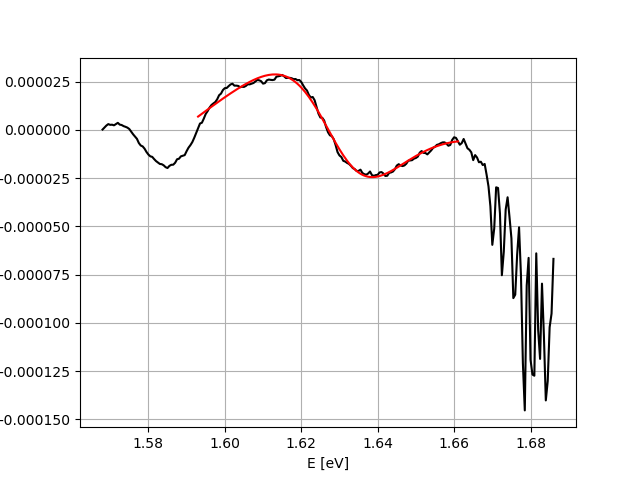

In [101]:
# Fitting range for the fifth transition
start_energy, stop_energy = 1.5928, 1.6617

# Fitting params
n = 2
#          A1    B1    C1   D1      T1   E1    G1 
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 50

print(initial_guess)
start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy_wr[start_idx:stop_idx], y_wr[start_idx:stop_idx]
x_contex = energy_wr[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y_wr[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
y_fitted = fit_pr(x_fit, *params_final)

print(params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='red')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

global_results_wr['T5'] = Result(
    name = 'PR WR V transition',
    color = 'blue',
    energy_start = start_energy,
    energy_idx_start = start_idx,
    energy_stop = stop_energy,
    energy_idx_stop = stop_idx,
    sd = 1,
    n = n,
    fitted_params = fit_pr1_to_dict(params_final),
    covariance = covariance,
    y_fitted = y_fitted,
    x_fit = x_fit
)

# All Transition 

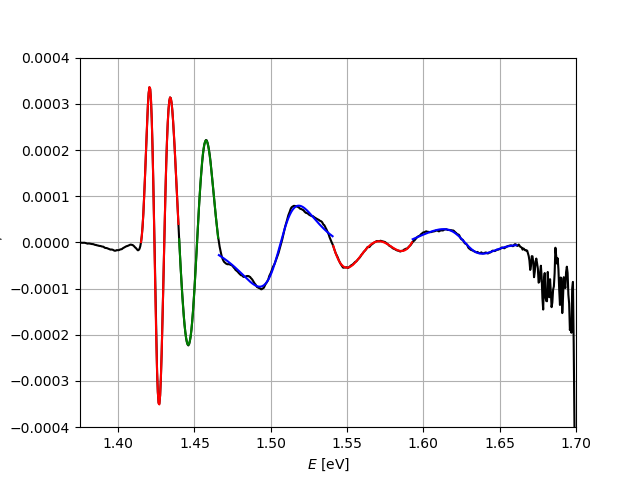

In [102]:
plt.figure()
# Plot base
plt.plot(energy_wr, y_wr, color='black')
# Apply results
for r in global_results_wr.values():
    plt.plot(r.x_fit, r.y_fitted, color=r.color)
plt.xlabel(r'$E $ [eV]')
plt.ylabel(r'$\Delta R / R$')
plt.ylim(-0.0004, 0.0004)
plt.xlim(1.375, 1.7)
plt.grid(True)
plt.show()


# Photoreflectance

Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

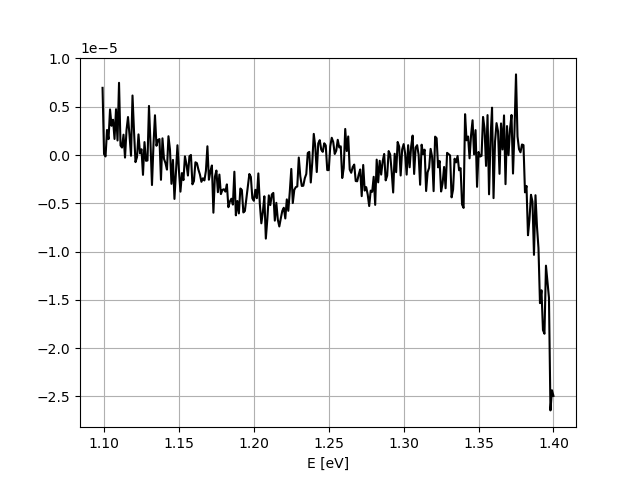

In [103]:
energy = pl25_df['energy']
pl = pl25_df['AC_X']
pr = pr25_df['AC_X']
r = pr25_df['DC_R']
y = (pr-pl)/r

plt.figure()
plt.plot(energy, y, color='black')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

[0.0, 0.0, 0.0, 0.0002, 0.1, 0.0, 0.0]
Fitting from 1.13 eV to 1.28 eV, idx: 31, 181
Params [ 3.18333770e-04 -4.81464012e-04  1.78052401e-04  9.26205155e-09
 -2.51775365e+00  1.24350480e+00 -3.69755017e-02]
 Covariance: [[ 1.51264095e-07 -2.55767737e-07  1.07905529e-07 -1.38627707e-12
  -9.98564187e-05  8.90869001e-07  1.97764230e-06]
 [-2.55767737e-07  4.32540936e-07 -1.82514425e-07  2.36315314e-12
   1.67889295e-04 -1.48880882e-06 -3.37016458e-06]
 [ 1.07905529e-07 -1.82514425e-07  7.70264436e-08 -1.00514745e-12
  -7.04008891e-05  6.20271801e-07  1.43296812e-06]
 [-1.38627707e-12  2.36315314e-12 -1.00514745e-12  1.88294622e-17
   6.58701578e-10 -3.35799934e-12 -2.71626626e-11]
 [-9.98564187e-05  1.67889295e-04 -7.04008891e-05  6.58701578e-10
   1.10769545e-01 -1.35536060e-03 -1.02422580e-03]
 [ 8.90869001e-07 -1.48880882e-06  6.20271801e-07 -3.35799934e-12
  -1.35536060e-03  1.92822948e-05  6.11581092e-06]
 [ 1.97764230e-06 -3.37016458e-06  1.43296812e-06 -2.71626626e-11
  -1.0242258

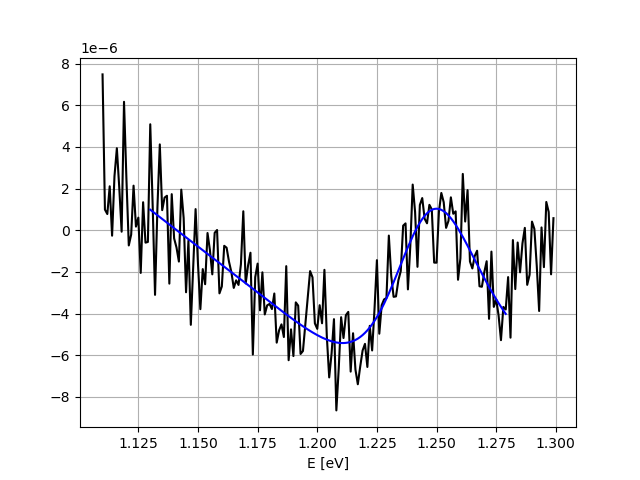

In [104]:
# Fitting range for the second transition
start_energy, stop_energy = 1.13, 1.28

# Fitting params
n = 2
params1 = [0.00, 0.00, 0.0, 0.0002, 0.1, 0.00, 0.00]

# Single function used
fit_pr = fit_pr1_generic(n)

# Both-sided context
margin_idx = 20

print(initial_guess)
start_idx, stop_idx = ((energy - start_energy).abs().idxmin()), ((energy - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')
x_fit, y_fit = energy[start_idx:stop_idx], y[start_idx:stop_idx]
x_contex = energy[(start_idx - margin_idx):(stop_idx + margin_idx)] 
y_contex = y[(start_idx - margin_idx):(stop_idx + margin_idx)]
initial_guess = params1
params_final, covariance = curve_fit(fit_pr, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_pr(x_fit, *params_final)

plt.figure()
plt.plot(x_contex, y_contex, color='black')
plt.plot(x_fit, y_fitted, color='blue')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# global_results['T2'] = Result(
#     name = 'PR NR I transition',
#     color = 'green',
#     energy_start = start_energy,
#     energy_idx_start = start_idx,
#     energy_stop = stop_energy,
#     energy_idx_stop = stop_idx,
#     fitted_params = params_final,
#     covariance = covariance,
#     y_fitted = y_fitted,
#     x_fit = x_fit
# )


# Module

Laser: 0,7mW \
Detection Range: <1,1;1,7> eV (wide)

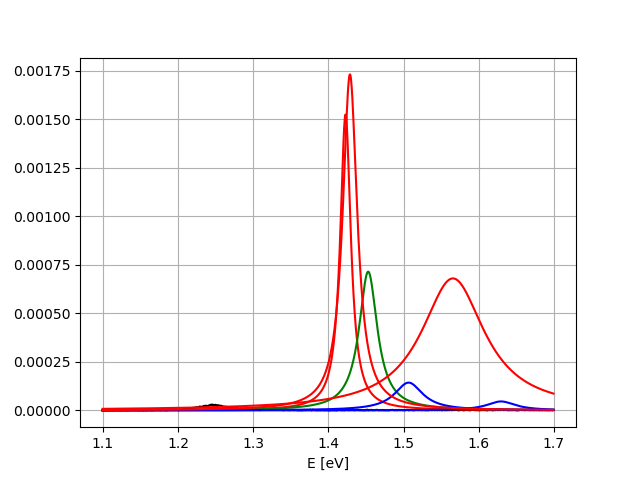

In [105]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.15, 1.35

# Fitting params
n = 2
params1 = [
    0.001, #D
    0.001, #E
    0.001, #G
]

# Single function used
fit_module = fit_module_generic(n)

energy_wr = pl07wr_df['energy']
ac_x_wr = pl07wr_df['AC_X']
ac_y_wr = pl07wr_df['AC_Y']
r_wr = pl07wr_df['AC_R']
r_calc_wr = np.sqrt((ac_x_wr**2)+(ac_y_wr**2))

# start_idx, stop_idx = ((energy_wr - start_energy).abs().idxmin()), ((energy_wr - stop_energy).abs().idxmin())
# print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')

# x_fit, y_fit = energy_wr[start_idx:stop_idx], r_wr[start_idx:stop_idx]

# initial_guess = params1
# params_final, covariance = curve_fit(fit_module, x_fit, y_fit, p0=initial_guess, maxfev=60000)
# print(f'Params {params_final}\n Covariance: {covariance}')
# y_fitted = fit_module(x_fit, *params_final)

plt.figure()
plt.plot(energy_wr, r_wr, color='black')
for r in global_results_wr.values():
    y = fit_module1_calc(r.n, energy_wr, r.fitted_params)
    plt.plot(energy_wr, y, color=r.color)
    
r = global_results_wr['T1']
y = fit_module12_calc(r.n, energy_wr, r.fitted_params)
plt.plot(energy_wr, y, color=r.color)

plt.xlabel('E [eV]')
plt.grid(True)
plt.show()

# Module

Laser: 2,5mW \
Detection Range: <1,1;1,4> eV

Fitting from 1.15 eV to 1.35 eV, idx: 51, 251
Params [2.87619035e-05 6.27827713e+00 2.69365254e+04]
 Covariance: [[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


/tmp/nix-shell.mW820Z/ipykernel_83610/1001519217.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  params_final, covariance = curve_fit(fit_module, x_fit, y_fit, p0=initial_guess, maxfev=60000)


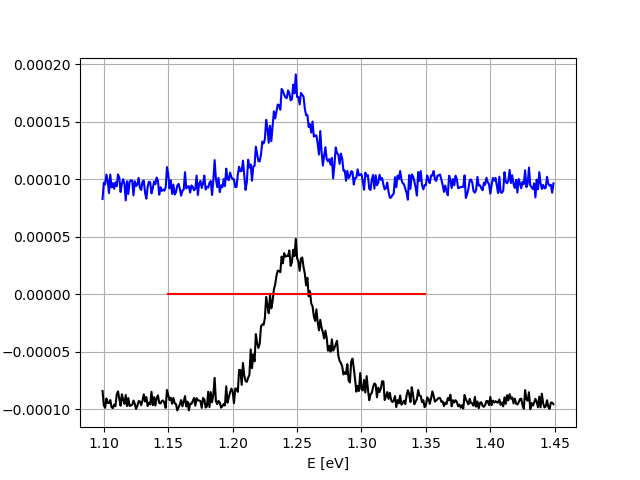

In [106]:
# Fitting range for the fourth transition
start_energy, stop_energy = 1.15, 1.35

# Fitting params
n = 2
params1 = [
    0.001,
    0.001,
    0.001,
]

# Single function used
fit_module = fit_module_generic(n)

energy = pl25_df['energy']
ac_x = pl25_df['AC_X']
ac_y = pl25_df['AC_Y']
r = pl25_df['AC_R']
r_calc = np.sqrt((ac_x**2)+(ac_y**2))

start_idx, stop_idx = ((energy - start_energy).abs().idxmin()), ((energy - stop_energy).abs().idxmin())
print(f'Fitting from {start_energy} eV to {stop_energy} eV, idx: {start_idx}, {stop_idx}')

x_fit, y_fit = energy[start_idx:stop_idx], r[start_idx:stop_idx]

initial_guess = params1
params_final, covariance = curve_fit(fit_module, x_fit, y_fit, p0=initial_guess, maxfev=60000)
print(f'Params {params_final}\n Covariance: {covariance}')
y_fitted = fit_module(x_fit, *params_final)

plt.figure()
plt.plot(energy, r, color='black')
plt.plot(energy, r_calc, color='blue')
plt.plot(x_fit, y_fitted, color='red')
plt.xlabel('E [eV]')
plt.grid(True)
plt.show()